## Importations

In [1]:
# Run Keras on CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152

In [2]:
# Importations
import sys
sys.path.append(os.path.join('..','utils'))

from configtf2 import *
import CPutils_tf2
import feature_extraction_tf2

In [3]:
# GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# Custom metrics

In [4]:
# Backend importation
import tensorflow.keras.backend as K

# Custom metrics
def specificity(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# One class accuracy
INTERESTING_CLASS_ID = 1  # Choose the class of interest
def single_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, INTERESTING_CLASS_ID), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

# Loss function 
def specificity_loss_wrapper():
    """A wrapper to create and return a function which computes the specificity loss, as (1 - specificity)

    """
    # Define the function for your loss
    def specificity_loss(y_true, y_pred):
        return 1.0 - specificity(y_true, y_pred)

    return specificity_loss    # we return this function object

# Data (Gray)

In [5]:
# GLobal directories
BASE_PATH = os.path.join('..', '..', 'data')
FULL_DATA_PATH = os.path.join('..', '..', 'data', 'dataset')
FIRE_PATH = os.path.join('..', '..', 'data', 'fire')
NO_FIRE_PATH = os.path.join('..', '..', 'data', 'no_fire')

In [6]:
# Load original dataset, smote augmented, and independent testing set
Data, labels = cload(os.path.join(BASE_PATH, 'OR_data.lzma'), compression='lzma')

In [7]:
# Full dataset
PATH = os.path.join('Consolidated_allTopologiesPNG', 'dataset')
testSet = list(CPutils_tf2.paths.list_images(PATH))

# Images
imgs = [cv2.imread(imgpath, -1)[:31,:38,0] for imgpath in testSet]
forbiddenSet = set([])
for idx,i in enumerate(imgs):
    if i.shape != (31,38):
        forbiddenSet.add(idx)
        
imgsclean = []
for idx,i in enumerate(imgs):
    if idx not in forbiddenSet:
        imgsclean.append(i)

# Labels
y = []
for idx, imgpath in enumerate(testSet):
    if idx not in forbiddenSet:
        n = imgpath.split(os.path.sep)[-1].split('_')[0]
        y.append(int(n))

# Sets
X = np.array(imgsclean) / 255.
y = np.array(y)
X.shape, y.shape

((76844, 31, 38), (76844,))

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

<Figure size 432x288 with 0 Axes>

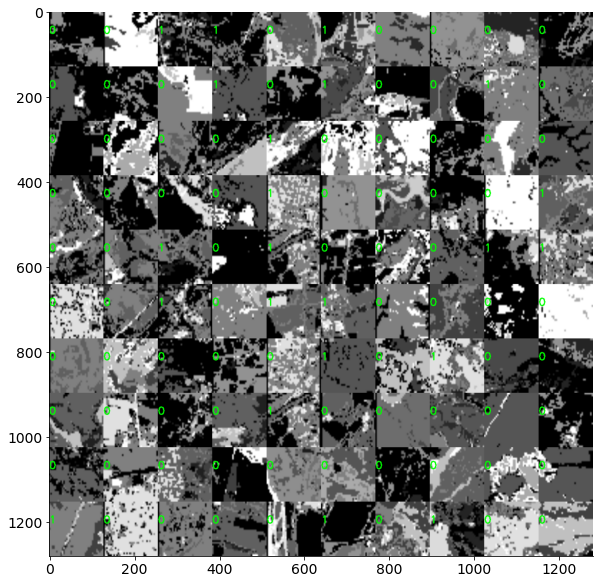

In [9]:
# Sample (quick look 100 images from dataset)
CPutils_tf2.plt_style(figsize=(10,10))
_ = CPutils_tf2.collage(images=Data * 255., 
                        seed=123,
                        imagesize=(128,128),
                        collagesize=(10,10),
                        sampleSize=100,
                        readImage=False,
                        show=False,
                        labels=labels.astype('str'))
plt.imshow(np.array(_)[0,:,:,:], cmap='gray')

# CNNet

In [10]:
# Import model and initialize a testing model
from nets_tf2.firenet import FireNet
dims = (Xtrain.shape[2], Xtrain.shape[1], 1)
model = FireNet.build_model(width=dims[0], height=dims[1], depth=dims[2], classes=2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 31, 38, 32)        73        
_________________________________________________________________
activation (Activation)      (None, 31, 38, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 38, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 19, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 19, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 15, 19, 64)        2400      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 19, 64)        0

## Class weights

In [11]:
from sklearn.utils import class_weight
classWeight = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(ytrain),
                                                y=ytrain)
classWeight = {idx:i for idx,i in enumerate(classWeight)}
classWeight

{0: 0.6303372998512555, 1: 2.418100193001594}

## Model Training

In [12]:
# Callbacks
plot_losses = CPutils_tf2.TrainingPlot(5)
checkpoint = ModelCheckpoint(filepath=os.path.join('_Full_ROS_11052021.h5'), 
                             save_best_only=True,
                             monitor='val_accuracy')
checkpoint2 = ModelCheckpoint(filepath=os.path.join('_Full_ROS_11052021_singleAcc.h5'), 
                             save_best_only=True,
                             monitor='val_single_class_accuracy')
callback_list = [plot_losses, checkpoint, checkpoint2]

In [13]:
# Optimizer
from tensorflow.keras.optimizers import Adagrad

# Compile our model (this needs to be done after our setting our layers to being non-trainable)
print("[INFO] compiling model...")

# Global parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32

# Optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

# Compilation
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[specificity, sensitivity, single_class_accuracy, 'accuracy'])

[INFO] compiling model...


In [14]:
# Global parameters
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

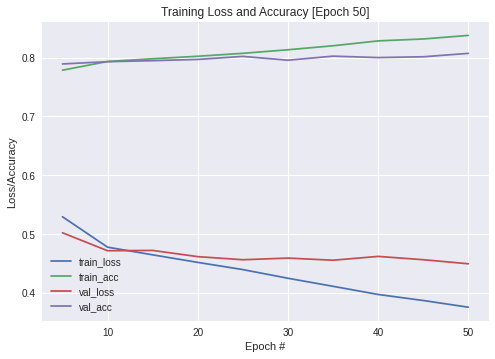

Epoch 47/50
1802/1802 [==============================] - 20s 11ms/step - loss: 0.3751 - specificity: 0.8138 - sensitivity: 0.8375 - single_class_accuracy: 0.7030 - accuracy: 0.8375 - val_loss: 0.4529 - val_specificity: 0.7787 - val_sensitivity: 0.8038 - val_single_class_accuracy: 0.5347 - val_accuracy: 0.8039
Epoch 48/50
1802/1802 [==============================] - 20s 11ms/step - loss: 0.3661 - specificity: 0.8202 - sensitivity: 0.8438 - single_class_accuracy: 0.7172 - accuracy: 0.8438 - val_loss: 0.4581 - val_specificity: 0.7794 - val_sensitivity: 0.8023 - val_single_class_accuracy: 0.5300 - val_accuracy: 0.8024
Epoch 49/50
1802/1802 [==============================] - 20s 11ms/step - loss: 0.3687 - specificity: 0.8166 - sensitivity: 0.8392 - single_class_accuracy: 0.6958 - accuracy: 0.8392 - val_loss: 0.4512 - val_specificity: 0.7815 - val_sensitivity: 0.8060 - val_single_class_accuracy: 0.5478 - val_accuracy: 0.8059
Epoch 50/50
1802/1802 [==============================] - 20s 11ms/s

In [15]:
# Train (explicit validation and train sets)
from tensorflow.keras.utils import to_categorical
weightsTrain = False
print("Training the model...")
H = model.fit(np.expand_dims(Xtrain, -1), 
              to_categorical(ytrain).astype(int),
              validation_data=(np.expand_dims(Xtest, -1), to_categorical(ytest).astype(int)),
              batch_size=BS, 
              epochs=EPOCHS,
              verbose=1,
              callbacks=callback_list,
              class_weight=classWeight if weightsTrain else None,)

## Evaluation

In [16]:
# Importations for evaluation
from sklearn.metrics import (mean_squared_error, roc_auc_score, auc, 
                             confusion_matrix, accuracy_score, classification_report,
                             precision_score, recall_score, f1_score, cohen_kappa_score)

### Validation set

In [19]:
# Predict over the original images
# Get Test truth and hat
y_hat = model.predict(np.expand_dims(Xtest, -1))
ytest = ytest

# Evaluation
print("Test accuracy [%]:", np.round(accuracy_score(y_true=ytest, y_pred=y_hat.argmax(1)) * 100, 2))
print("Precision Score:", np.round(precision_score(y_true=ytest, y_pred=y_hat.argmax(1)),3))
print("Recall score:", np.round(recall_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("F1 score:", np.round(f1_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("Cohen Kappa score:", np.round(cohen_kappa_score(ytest, y_hat.argmax(1)),3))
print("ROC AUC score:", np.round(roc_auc_score(y_true=ytest, y_score=y_hat[:,1]), 3))
tn, fp, fn, tp = confusion_matrix(ytest, y_hat.argmax(1)).ravel()
print("Specificity:", tn / (tn+fp))
print("Sensitivity:", tp / (tp+fn))
print(confusion_matrix(ytest, y_hat.argmax(1)))

Test accuracy [%]: 80.11
Precision Score: 0.531
Recall score: 0.305
F1 score: 0.388
Cohen Kappa score: 0.279
ROC AUC score: 0.747
Specificity: 0.9299580272822665
Sensitivity: 0.30507191521574567
[[14180  1068]
 [ 2754  1209]]


### Whole dataset

In [20]:
# Predict over the original images
# Get Test truth and hat
y_hat = model.predict(np.expand_dims(Data, -1))
ytest = labels

# Evaluation
print("Test accuracy [%]:", np.round(accuracy_score(y_true=ytest, y_pred=y_hat.argmax(1)) * 100, 2))
print("Precision Score:", np.round(precision_score(y_true=ytest, y_pred=y_hat.argmax(1)),3))
print("Recall score:", np.round(recall_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("F1 score:", np.round(f1_score(y_true=ytest, y_pred=y_hat.argmax(1)), 3))
print("Cohen Kappa score:", np.round(cohen_kappa_score(ytest, y_hat.argmax(1)),3))
print("ROC AUC score:", np.round(roc_auc_score(y_true=ytest, y_score=y_hat[:,1]), 3))
tn, fp, fn, tp = confusion_matrix(ytest, y_hat.argmax(1)).ravel()
print("Specificity:", tn / (tn+fp))
print("Sensitivity:", tp / (tp+fn))
print(confusion_matrix(ytest, y_hat.argmax(1)))

Test accuracy [%]: 79.98
Precision Score: 0.5
Recall score: 0.277
F1 score: 0.357
Cohen Kappa score: 0.25
ROC AUC score: 0.735
Specificity: 0.9305782772601181
Sensitivity: 0.2772727272727273
[[13083   976]
 [ 2544   976]]
